In [1]:
# ================================================================
# SNAPSHELF AI - YOLOv8 CLASSIFICATION
# ================================================================
# Project:      SnapShelf - Smart Food Inventory Management
# Module:       MOD002691 - Final Project (BSc Software Engineering)
# Institution:  Anglia Ruskin University, Cambridge
# Author:       Oriol Morros Vilaseca (SID: 2270056)
# Supervisor:   Mr Vitaliy Milke
# Date:         January 2026
# ================================================================
#
# PURPOSE:
# This notebook trains a YOLOv8 classification model for food image
# classification. While YOLO is primarily known for object detection,
# YOLOv8 includes a classification mode that allows direct comparison
# with CNN and EfficientNet approaches.
#
# This is Model 3 of 3 in the comparison study:
#   1. Custom CNN (trained from scratch)
#   2. EfficientNetB0 (transfer learning)
#   3. YOLOv8 (this notebook)
#
# RESEARCH QUESTION:
# How do different image classification approaches compare in
# accuracy, inference time, and computational efficiency for
# household food item recognition?
#
# INPUT:
#   - snapshelf_dataset_14classes_70-15-15.zip (from Notebook 01)
#
# OUTPUT:
#   - Trained model: snapshelf_yolov8_cls.pt
#   - Training history and metrics
#   - Evaluation results on test set
#
# ================================================================

import sys
import platform
from datetime import datetime

print("=" * 65)
print("SNAPSHELF AI - YOLOv8 CLASSIFICATION")
print("=" * 65)
print(f"Execution Date:  {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Python Version:  {sys.version.split()[0]}")
print(f"Platform:        {platform.platform()}")
print("=" * 65)

SNAPSHELF AI - YOLOv8 CLASSIFICATION
Execution Date:  2026-01-04 11:12:19
Python Version:  3.12.12
Platform:        Linux-6.6.105+-x86_64-with-glibc2.35


In [2]:
# ================================================================
# CELL 2: INSTALL ULTRALYTICS & IMPORT LIBRARIES
# ================================================================
# YOLOv8 is provided by Ultralytics.
# Installation is required as it's not pre-installed in Colab.
# ================================================================

# Install ultralytics package
print("Installing Ultralytics (YOLOv8)...")
!pip install ultralytics --quiet

import os
import zipfile
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path

# Ultralytics YOLO
from ultralytics import YOLO

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# -----------------------------
# CHECK GPU AVAILABILITY
# -----------------------------
import torch

print("\n" + "=" * 65)
print("ENVIRONMENT CHECK")
print("=" * 65)

print(f"\nPyTorch Version:    {torch.__version__}")
print(f"CUDA Available:     {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU Device:         {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory:         {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("WARNING: No GPU detected. Training will be slow.")

print(f"Random Seed:        {SEED}")
print(f"\nLibraries imported successfully.")

Installing Ultralytics (YOLOv8)...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.2 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

ENVIRONMENT CHECK

PyTorch Version:    2.9.0+cu126
CUDA Available:     True
GPU Device:         Tesla T4
GPU Memory:         15.8 GB
Random Seed:        42

Libraries imported successfully.


In [3]:
# ================================================================
# CELL 3: MOUNT GOOGLE DRIVE & LOAD DATASET
# ================================================================
# Loads the prepared dataset from Notebook 01.
# YOLO expects a specific directory structure which we already have.
# ================================================================

from google.colab import drive

# Mount Google Drive
if not os.path.exists('/content/drive/MyDrive'):
    drive.mount('/content/drive')

# -----------------------------
# CONFIGURATION
# -----------------------------
DATASET_ZIP = "/content/drive/MyDrive/snapshelf_datasets/snapshelf_dataset_14classes_70-15-15.zip"
LOCAL_DATASET = "/content/snapshelf_dataset"

print("=" * 65)
print("LOADING DATASET")
print("=" * 65)

# Verify zip file exists
if not os.path.exists(DATASET_ZIP):
    raise FileNotFoundError(f"Dataset not found: {DATASET_ZIP}")

zip_size_mb = os.path.getsize(DATASET_ZIP) / (1024 * 1024)
print(f"\nDataset archive: {DATASET_ZIP}")
print(f"Archive size:    {zip_size_mb:.1f} MB")

# -----------------------------
# EXTRACT DATASET
# -----------------------------
print(f"\nExtracting to: {LOCAL_DATASET}")

# Clean extraction directory
if os.path.exists(LOCAL_DATASET):
    shutil.rmtree(LOCAL_DATASET)

# Extract
with zipfile.ZipFile(DATASET_ZIP, 'r') as zip_ref:
    zip_ref.extractall(LOCAL_DATASET)

print("Extraction complete.")

# -----------------------------
# VERIFY STRUCTURE
# -----------------------------
TRAIN_DIR = f"{LOCAL_DATASET}/train"
VAL_DIR = f"{LOCAL_DATASET}/val"
TEST_DIR = f"{LOCAL_DATASET}/test"

print(f"\nDataset structure:")
for split_name, split_dir in [("Train", TRAIN_DIR), ("Val", VAL_DIR), ("Test", TEST_DIR)]:
    if os.path.exists(split_dir):
        n_classes = len(os.listdir(split_dir))
        n_images = sum(len(files) for _, _, files in os.walk(split_dir))
        print(f"  {split_name + ':':<8} {n_classes} classes, {n_images:,} images")
    else:
        print(f"  {split_name}: NOT FOUND")

# Get class names
CLASS_NAMES = sorted(os.listdir(TRAIN_DIR))
NUM_CLASSES = len(CLASS_NAMES)

print(f"\nClasses ({NUM_CLASSES}): {', '.join(CLASS_NAMES)}")

Mounted at /content/drive
LOADING DATASET

Dataset archive: /content/drive/MyDrive/snapshelf_datasets/snapshelf_dataset_14classes_70-15-15.zip
Archive size:    2445.3 MB

Extracting to: /content/snapshelf_dataset
Extraction complete.

Dataset structure:
  Train:   14 classes, 117,151 images
  Val:     14 classes, 25,099 images
  Test:    14 classes, 25,116 images

Classes (14): apple, banana, bell_pepper_green, bell_pepper_red, carrot, cucumber, grape, lemon, onion, orange, peach, potato, strawberry, tomato


In [4]:
# ================================================================
# CELL 4: CONFIGURE YOLOv8 MODEL
# ================================================================
# YOLOv8 provides classification models (yolov8n-cls, yolov8s-cls, etc.)
# We use yolov8s-cls (small) for balance of speed and accuracy.
#
# Model sizes:
#   - yolov8n-cls: nano (fastest, least accurate)
#   - yolov8s-cls: small (balanced)
#   - yolov8m-cls: medium
#   - yolov8l-cls: large
#   - yolov8x-cls: extra large (slowest, most accurate)
# ================================================================

print("=" * 65)
print("CONFIGURING YOLOv8 MODEL")
print("=" * 65)

# -----------------------------
# MODEL SELECTION
# -----------------------------
MODEL_VARIANT = 'yolov8s-cls'  # Small classification model

print(f"\nLoading pre-trained model: {MODEL_VARIANT}")
model = YOLO(f'{MODEL_VARIANT}.pt')

print(f"Model loaded successfully.")

# -----------------------------
# TRAINING PARAMETERS
# -----------------------------
IMG_SIZE = 224          # Standard input size for classification
BATCH_SIZE = 32         # Suitable for Colab GPU
EPOCHS = 30             # Maximum epochs (early stopping may trigger)
PATIENCE = 5            # Early stopping patience

# Output directory for training runs
PROJECT_DIR = "/content/yolo_training"
RUN_NAME = "snapshelf_cls"

print(f"\nTraining Configuration:")
print(f"  Model:          {MODEL_VARIANT}")
print(f"  Image size:     {IMG_SIZE}x{IMG_SIZE}")
print(f"  Batch size:     {BATCH_SIZE}")
print(f"  Max epochs:     {EPOCHS}")
print(f"  Early stopping: patience={PATIENCE}")
print(f"  Output dir:     {PROJECT_DIR}/{RUN_NAME}")

CONFIGURING YOLOv8 MODEL

Loading pre-trained model: yolov8s-cls
Model loaded successfully.

Training Configuration:
  Model:          yolov8s-cls
  Image size:     224x224
  Batch size:     32
  Max epochs:     30
  Early stopping: patience=5
  Output dir:     /content/yolo_training/snapshelf_cls


In [5]:
# ================================================================
# CELL 5: TRAIN YOLOv8 MODEL
# ================================================================
# YOLOv8 handles data loading, augmentation, and training internally.
# The train() method expects the path to the dataset root directory.
# ================================================================

print("=" * 65)
print("TRAINING YOLOv8 CLASSIFICATION MODEL")
print("=" * 65)

print(f"\nStarting training at: {datetime.now().strftime('%H:%M:%S')}")
print(f"Training on {TRAIN_DIR}")
print(f"Validating on {VAL_DIR}")
print("-" * 65)

# Record start time
training_start = datetime.now()

# Train the model
results = model.train(
    data=LOCAL_DATASET,       # Path to dataset (contains train/val/test folders)
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    patience=PATIENCE,        # Early stopping patience
    project=PROJECT_DIR,
    name=RUN_NAME,
    exist_ok=True,
    verbose=True,
    seed=SEED,

    # Augmentation settings (similar to our other models)
    hsv_h=0.015,              # HSV hue augmentation
    hsv_s=0.7,                # HSV saturation augmentation
    hsv_v=0.4,                # HSV value augmentation
    degrees=20.0,             # Rotation augmentation
    translate=0.1,            # Translation augmentation
    scale=0.1,                # Scale augmentation
    fliplr=0.5,               # Horizontal flip probability
    flipud=0.0,               # Vertical flip probability (disabled)
)

# Record end time
training_end = datetime.now()
training_duration = training_end - training_start
TRAINING_TIME_SECONDS = training_duration.total_seconds()

print("-" * 65)
print(f"Training completed at: {training_end.strftime('%H:%M:%S')}")
print(f"Total training time:   {training_duration}")

TRAINING YOLOv8 CLASSIFICATION MODEL

Starting training at: 11:15:09
Training on /content/snapshelf_dataset/train
Validating on /content/snapshelf_dataset/val
-----------------------------------------------------------------
Ultralytics 8.3.247 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/snapshelf_dataset, degrees=20.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.

In [6]:
# ================================================================
# CELL 6: LOAD BEST MODEL & TRAINING RESULTS
# ================================================================
# YOLOv8 automatically saves the best model during training.
# ================================================================

print("=" * 65)
print("LOADING TRAINING RESULTS")
print("=" * 65)

# Path to best model
BEST_MODEL_PATH = f"{PROJECT_DIR}/{RUN_NAME}/weights/best.pt"
LAST_MODEL_PATH = f"{PROJECT_DIR}/{RUN_NAME}/weights/last.pt"

print(f"\nBest model path: {BEST_MODEL_PATH}")

# Load best model for evaluation
best_model = YOLO(BEST_MODEL_PATH)
print("Best model loaded successfully.")

# Load training results CSV
RESULTS_CSV = f"{PROJECT_DIR}/{RUN_NAME}/results.csv"

import pandas as pd
if os.path.exists(RESULTS_CSV):
    training_history = pd.read_csv(RESULTS_CSV)
    training_history.columns = training_history.columns.str.strip()
    print(f"\nTraining history loaded: {len(training_history)} epochs")
    print(f"Columns: {list(training_history.columns)}")
else:
    print(f"WARNING: Results CSV not found at {RESULTS_CSV}")

LOADING TRAINING RESULTS

Best model path: /content/yolo_training/snapshelf_cls/weights/best.pt
Best model loaded successfully.

Training history loaded: 13 epochs
Columns: ['epoch', 'time', 'train/loss', 'metrics/accuracy_top1', 'metrics/accuracy_top5', 'val/loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


TRAINING HISTORY


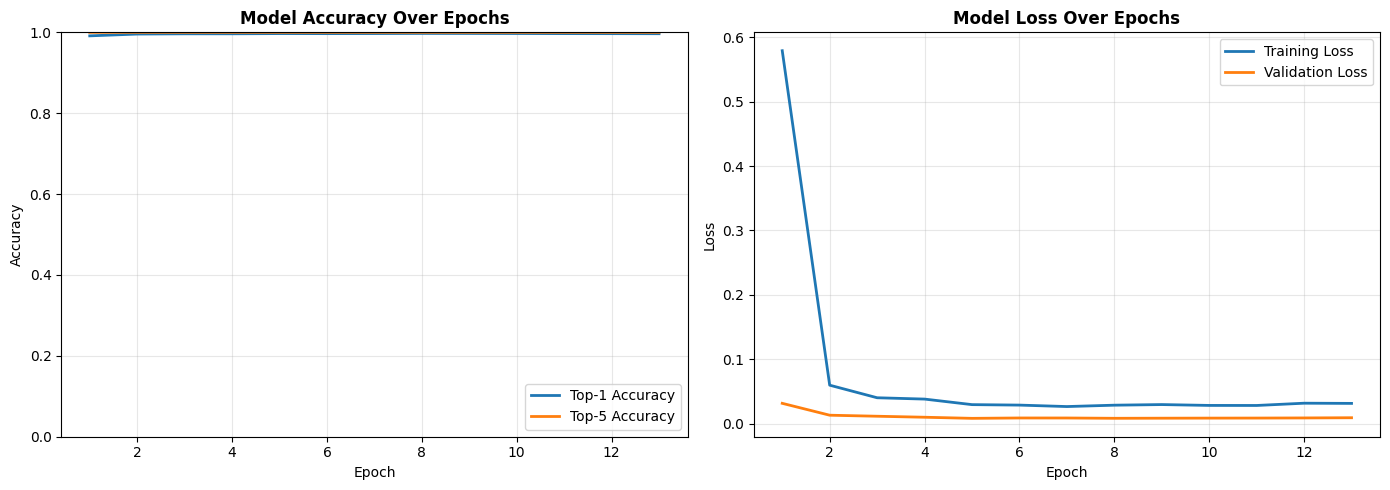


Plot saved to: /content/yolo_training_history.png

Training Summary:
  Total epochs:       13
  Best epoch:         8
  Best val accuracy:  0.9973 (99.73%)
  Training time:      0:37:45.822346


In [7]:
# ================================================================
# CELL 7: PLOT TRAINING HISTORY
# ================================================================
# Visualizes training metrics over epochs.
# ================================================================

print("=" * 65)
print("TRAINING HISTORY")
print("=" * 65)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# -----------------------------
# ACCURACY PLOT
# -----------------------------
if 'metrics/accuracy_top1' in training_history.columns:
    axes[0].plot(training_history['epoch'], training_history['metrics/accuracy_top1'],
                 label='Top-1 Accuracy', linewidth=2)
if 'metrics/accuracy_top5' in training_history.columns:
    axes[0].plot(training_history['epoch'], training_history['metrics/accuracy_top5'],
                 label='Top-5 Accuracy', linewidth=2)

axes[0].set_title('Model Accuracy Over Epochs', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1])

# -----------------------------
# LOSS PLOT
# -----------------------------
if 'train/loss' in training_history.columns:
    axes[1].plot(training_history['epoch'], training_history['train/loss'],
                 label='Training Loss', linewidth=2)
if 'val/loss' in training_history.columns:
    axes[1].plot(training_history['epoch'], training_history['val/loss'],
                 label='Validation Loss', linewidth=2)

axes[1].set_title('Model Loss Over Epochs', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/yolo_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to: /content/yolo_training_history.png")

# -----------------------------
# TRAINING SUMMARY
# -----------------------------
if 'metrics/accuracy_top1' in training_history.columns:
    best_acc = training_history['metrics/accuracy_top1'].max()
    best_epoch = training_history['metrics/accuracy_top1'].idxmax() + 1
    print(f"\nTraining Summary:")
    print(f"  Total epochs:       {len(training_history)}")
    print(f"  Best epoch:         {best_epoch}")
    print(f"  Best val accuracy:  {best_acc:.4f} ({best_acc*100:.2f}%)")
    print(f"  Training time:      {training_duration}")

In [8]:
# ================================================================
# CELL 8: EVALUATE ON TEST SET
# ================================================================
# Final evaluation on the held-out test set.
# ================================================================

print("=" * 65)
print("TEST SET EVALUATION")
print("=" * 65)

print(f"\nEvaluating on: {TEST_DIR}")

# Run validation on test set
test_results = best_model.val(
    data=LOCAL_DATASET,
    split='test',
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    verbose=True
)

# Extract metrics
test_accuracy_top1 = test_results.top1
test_accuracy_top5 = test_results.top5

print(f"\n{'=' * 40}")
print(f"TEST RESULTS")
print(f"{'=' * 40}")
print(f"Top-1 Accuracy: {test_accuracy_top1:.4f} ({test_accuracy_top1*100:.2f}%)")
print(f"Top-5 Accuracy: {test_accuracy_top5:.4f} ({test_accuracy_top5*100:.2f}%)")

TEST SET EVALUATION

Evaluating on: /content/snapshelf_dataset/test
Ultralytics 8.3.247 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s-cls summary (fused): 30 layers, 5,093,134 parameters, 0 gradients, 12.5 GFLOPs
train: /content/snapshelf_dataset/train... found 117151 images in 14 classes ✅ 
val: /content/snapshelf_dataset/val... found 25099 images in 14 classes ✅ 
test: /content/snapshelf_dataset/test... found 25116 images in 14 classes ✅ 
test: Fast image access ✅ (ping: 0.0±0.0 ms, read: 447.8±385.4 MB/s, size: 11.5 KB)
test: Scanning /content/snapshelf_dataset/test... 25116 images, 0 corrupt: 100% ━━━━━━━━━━━━ 25116/25116 2.9Kit/s 8.5s
test: New cache created: /content/snapshelf_dataset/test.cache
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 785/785 43.7it/s 17.9s
                   all      0.997          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/runs/classify/val

TEST 

In [9]:
# ================================================================
# CELL 9: GENERATE PREDICTIONS & CLASSIFICATION REPORT
# ================================================================
# Generate predictions on all test images for detailed metrics.
# ================================================================

print("=" * 65)
print("DETAILED CLASSIFICATION METRICS")
print("=" * 65)

print("\nGenerating predictions on test set...")

# Get all test images
test_images = []
true_labels = []

for class_idx, class_name in enumerate(CLASS_NAMES):
    class_dir = os.path.join(TEST_DIR, class_name)
    if os.path.exists(class_dir):
        for img_name in os.listdir(class_dir):
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                test_images.append(os.path.join(class_dir, img_name))
                true_labels.append(class_idx)

print(f"Total test images: {len(test_images)}")

# Generate predictions in batches
predicted_labels = []
batch_size = 100

for i in range(0, len(test_images), batch_size):
    batch_imgs = test_images[i:i+batch_size]
    results = best_model.predict(batch_imgs, verbose=False)

    for r in results:
        pred_class = r.probs.top1
        predicted_labels.append(pred_class)

    if (i + batch_size) % 5000 == 0 or i + batch_size >= len(test_images):
        print(f"  Processed {min(i + batch_size, len(test_images)):,} / {len(test_images):,} images")

# Convert to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# -----------------------------
# CLASSIFICATION REPORT
# -----------------------------
print("\n" + "=" * 65)
print("CLASSIFICATION REPORT")
print("=" * 65)

report = classification_report(
    true_labels,
    predicted_labels,
    target_names=CLASS_NAMES,
    digits=4
)
print(report)

# Store report as dictionary
report_dict = classification_report(
    true_labels,
    predicted_labels,
    target_names=CLASS_NAMES,
    output_dict=True
)

# Calculate overall accuracy (should match top1)
test_accuracy = np.mean(true_labels == predicted_labels)
print(f"Overall Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

DETAILED CLASSIFICATION METRICS

Generating predictions on test set...
Total test images: 25116
  Processed 5,000 / 25,116 images
  Processed 10,000 / 25,116 images
  Processed 15,000 / 25,116 images
  Processed 20,000 / 25,116 images
  Processed 25,000 / 25,116 images
  Processed 25,116 / 25,116 images

CLASSIFICATION REPORT
                   precision    recall  f1-score   support

            apple     0.9971    0.9982    0.9976     10409
           banana     0.9825    0.9813    0.9819       856
bell_pepper_green     1.0000    1.0000    1.0000       156
  bell_pepper_red     1.0000    1.0000    1.0000       234
           carrot     1.0000    1.0000    1.0000        61
         cucumber     0.9992    1.0000    0.9996      2367
            grape     0.9917    0.9857    0.9887      1330
            lemon     1.0000    1.0000    1.0000       272
            onion     1.0000    1.0000    1.0000      1050
           orange     1.0000    1.0000    1.0000       489
            peach     

CONFUSION MATRIX


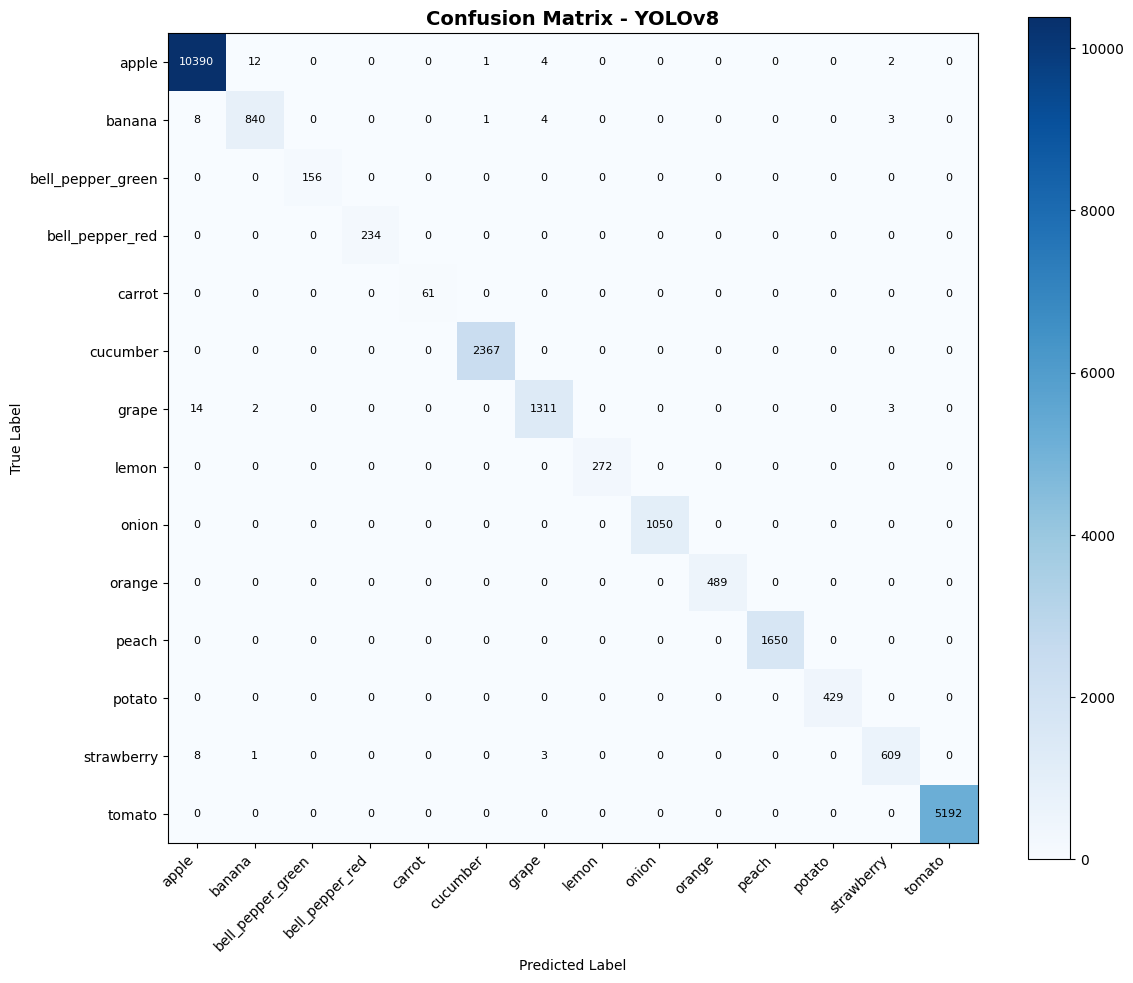


Confusion matrix saved to: /content/yolo_confusion_matrix.png


In [10]:
# ================================================================
# CELL 10: GENERATE CONFUSION MATRIX
# ================================================================
# Visualize classification performance across all classes.
# ================================================================

print("=" * 65)
print("CONFUSION MATRIX")
print("=" * 65)

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(12, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - YOLOv8', fontsize=14, fontweight='bold')
plt.colorbar()

tick_marks = np.arange(len(CLASS_NAMES))
plt.xticks(tick_marks, CLASS_NAMES, rotation=45, ha='right')
plt.yticks(tick_marks, CLASS_NAMES)

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=8)

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('/content/yolo_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nConfusion matrix saved to: /content/yolo_confusion_matrix.png")

In [11]:
# ================================================================
# CELL 11: MEASURE INFERENCE TIME
# ================================================================
# Measures average inference time per image.
# ================================================================

import time

print("=" * 65)
print("INFERENCE TIME MEASUREMENT")
print("=" * 65)

# Get a sample test image
sample_image = test_images[0]

# Warm-up run
_ = best_model.predict(sample_image, verbose=False)

# -----------------------------
# SINGLE IMAGE INFERENCE
# -----------------------------
print("\nMeasuring single image inference time...")

n_runs = 100
times = []

for _ in range(n_runs):
    start = time.perf_counter()
    _ = best_model.predict(sample_image, verbose=False)
    end = time.perf_counter()
    times.append((end - start) * 1000)

single_avg = np.mean(times)
single_std = np.std(times)

print(f"  Runs:          {n_runs}")
print(f"  Average:       {single_avg:.2f} ms")
print(f"  Std Dev:       {single_std:.2f} ms")

# -----------------------------
# BATCH INFERENCE
# -----------------------------
print("\nMeasuring batch inference time...")

batch_size = 32
batch_images = test_images[:batch_size]
n_runs = 50

times = []
for _ in range(n_runs):
    start = time.perf_counter()
    _ = best_model.predict(batch_images, verbose=False)
    end = time.perf_counter()
    times.append((end - start) * 1000)

batch_avg = np.mean(times)
batch_std = np.std(times)
per_image_batch = batch_avg / batch_size

print(f"  Batch size:    {batch_size}")
print(f"  Runs:          {n_runs}")
print(f"  Batch avg:     {batch_avg:.2f} ms")
print(f"  Per image:     {per_image_batch:.2f} ms")

# Store results
INFERENCE_TIME_SINGLE = single_avg
INFERENCE_TIME_BATCH = per_image_batch

print(f"\n{'=' * 40}")
print("INFERENCE TIME SUMMARY")
print(f"{'=' * 40}")
print(f"Single image:   {INFERENCE_TIME_SINGLE:.2f} ms")
print(f"Batched (x32):  {INFERENCE_TIME_BATCH:.2f} ms per image")

INFERENCE TIME MEASUREMENT

Measuring single image inference time...
  Runs:          100
  Average:       7.20 ms
  Std Dev:       0.34 ms

Measuring batch inference time...
  Batch size:    32
  Runs:          50
  Batch avg:     132.43 ms
  Per image:     4.14 ms

INFERENCE TIME SUMMARY
Single image:   7.20 ms
Batched (x32):  4.14 ms per image


In [12]:
# ================================================================
# CELL 12: SAVE MODEL & RESULTS SUMMARY
# ================================================================
# Saves the trained model and all metrics to Google Drive.
# ================================================================

import json

print("=" * 65)
print("SAVING MODEL & RESULTS")
print("=" * 65)

# -----------------------------
# SAVE MODEL TO DRIVE
# -----------------------------
DRIVE_MODEL_DIR = "/content/drive/MyDrive/snapshelf_models"
os.makedirs(DRIVE_MODEL_DIR, exist_ok=True)

MODEL_SAVE_PATH = f"{DRIVE_MODEL_DIR}/yolo_model.pt"

print(f"\nSaving model to: {MODEL_SAVE_PATH}")
shutil.copy(BEST_MODEL_PATH, MODEL_SAVE_PATH)
print("Model saved successfully.")

# Get model file size
model_size_mb = os.path.getsize(MODEL_SAVE_PATH) / (1024 * 1024)

# -----------------------------
# COMPILE RESULTS
# -----------------------------
results_data = {
    "model_name": "YOLOv8s-cls",
    "architecture": {
        "type": "YOLO Classification",
        "variant": MODEL_VARIANT,
        "pretrained_on": "ImageNet",
        "input_size": [IMG_SIZE, IMG_SIZE],
        "num_classes": NUM_CLASSES
    },
    "training": {
        "epochs_completed": len(training_history),
        "training_time_seconds": TRAINING_TIME_SECONDS,
        "batch_size": BATCH_SIZE,
        "patience": PATIENCE
    },
    "performance": {
        "test_accuracy_top1": float(test_accuracy_top1),
        "test_accuracy_top5": float(test_accuracy_top5)
    },
    "per_class_metrics": {
        class_name: {
            "precision": report_dict[class_name]["precision"],
            "recall": report_dict[class_name]["recall"],
            "f1_score": report_dict[class_name]["f1-score"],
            "support": report_dict[class_name]["support"]
        }
        for class_name in CLASS_NAMES
    },
    "efficiency": {
        "model_size_mb": round(model_size_mb, 2),
        "inference_time_single_ms": round(INFERENCE_TIME_SINGLE, 2),
        "inference_time_batch_ms": round(INFERENCE_TIME_BATCH, 2)
    }
}

# -----------------------------
# SAVE RESULTS JSON
# -----------------------------
RESULTS_PATH = f"{DRIVE_MODEL_DIR}/yolo_results.json"

print(f"\nSaving results to: {RESULTS_PATH}")
with open(RESULTS_PATH, 'w') as f:
    json.dump(results_data, f, indent=2)
print("Results saved successfully.")

# -----------------------------
# SAVE PLOTS TO DRIVE
# -----------------------------
print(f"\nSaving plots to Drive...")
shutil.copy('/content/yolo_training_history.png',
            f"{DRIVE_MODEL_DIR}/yolo_training_history.png")
shutil.copy('/content/yolo_confusion_matrix.png',
            f"{DRIVE_MODEL_DIR}/yolo_confusion_matrix.png")
print("Plots saved successfully.")

# -----------------------------
# PRINT FINAL SUMMARY
# -----------------------------
print("\n" + "=" * 65)
print("YOLOv8 - FINAL RESULTS SUMMARY")
print("=" * 65)

print(f"""
MODEL ARCHITECTURE
------------------
Type:               YOLOv8 Classification
Variant:            {MODEL_VARIANT}
Pre-trained on:     ImageNet
Input Size:         {IMG_SIZE}x{IMG_SIZE}
Model Size:         {model_size_mb:.2f} MB

TRAINING
--------
Epochs:             {len(training_history)}
Training Time:      {training_duration}

PERFORMANCE
-----------
Test Top-1 Accuracy:  {test_accuracy_top1*100:.2f}%
Test Top-5 Accuracy:  {test_accuracy_top5*100:.2f}%

EFFICIENCY
----------
Inference (single):   {INFERENCE_TIME_SINGLE:.2f} ms
Inference (batch):    {INFERENCE_TIME_BATCH:.2f} ms/image

FILES SAVED
-----------
Model:    {MODEL_SAVE_PATH}
Results:  {RESULTS_PATH}
Plots:    {DRIVE_MODEL_DIR}/yolo_*.png
""")

print("=" * 65)
print("NOTEBOOK 04 COMPLETE")
print("=" * 65)

SAVING MODEL & RESULTS

Saving model to: /content/drive/MyDrive/snapshelf_models/yolo_model.pt
Model saved successfully.

Saving results to: /content/drive/MyDrive/snapshelf_models/yolo_results.json
Results saved successfully.

Saving plots to Drive...
Plots saved successfully.

YOLOv8 - FINAL RESULTS SUMMARY

MODEL ARCHITECTURE
------------------
Type:               YOLOv8 Classification
Variant:            yolov8s-cls
Pre-trained on:     ImageNet
Input Size:         224x224
Model Size:         9.81 MB

TRAINING
--------
Epochs:             13
Training Time:      0:37:45.822346

PERFORMANCE
-----------
Test Top-1 Accuracy:  99.74%
Test Top-5 Accuracy:  100.00%

EFFICIENCY
----------
Inference (single):   7.20 ms
Inference (batch):    4.14 ms/image

FILES SAVED
-----------
Model:    /content/drive/MyDrive/snapshelf_models/yolo_model.pt
Results:  /content/drive/MyDrive/snapshelf_models/yolo_results.json
Plots:    /content/drive/MyDrive/snapshelf_models/yolo_*.png

NOTEBOOK 04 COMPLETE
